In [3]:
import torch
import torchaudio
import torch.nn as nn
from pypinyin import lazy_pinyin
import matplotlib
import matplotlib.pyplot as plt
# import os
# from torch.utils.data import Dataset, DataLoader, random_split

In [4]:
from pypinyin import Style, lazy_pinyin


initial_table = ['b', 'p', 'm', 'f',
                'd', 't', 'n', 'l',
                'g', 'k', 'h',
                'j', 'q', 'x',
                'zh', 'ch', 'sh', 'r', 'z', 'c', 's']

finals_table = [['i', 'u', 'v'], # 可以与下面的配成 iao, ue
                ['a', 'o', 'e', 
                'ai', 'ei', 'ao', 'ou', 
                'an', 'en', 'on', 'in', 'vn', 'un',
                'ang', 'eng', 'ong', 'ing', 'er']]

def get_labels():
    return ['-', '|'] + initial_table + finals_table[0] + finals_table[1]

def chinese2pinyin(text):
    initials = lazy_pinyin(text, strict=True, style=Style.INITIALS, errors=lambda x: u'')
    finals = lazy_pinyin(text, strict=True, style=Style.FINALS, errors=lambda x: u'')
    pinyin = []
    for i in range(len(finals)):
        # pinyin+=['|']
        if initials[i] != '':
            pinyin+=[initials[i]]
        if finals[i] != '':
            if len(finals[i])>1 and finals[i][0] in finals_table[0] and finals[i][1]!='n':
                pinyin+=[finals[i][0], finals[i][1:]]
            else: pinyin+=[finals[i]]
        if initials[i] == '' and finals[i] == '':
            pinyin+=['n']
    # if pinyin[-1] == '|':
    #     pinyin = pinyin[:-1]
    return pinyin[:]

','.join(chinese2pinyin('虐去无，恩，嗯好乌牛一呀忧元儿赢因翁'))

'n,v,e,q,v,u,en,n,h,ao,u,n,i,ou,i,i,a,i,ou,v,an,er,ing,in,u,eng'

In [5]:
from utils.chinese2pinyin2 import chinese2pinyin, get_labels

In [26]:
from utils.dataset import SpeechOceanDataset, STCMDSDataset
N_MELS = 80
def audio_transform(sample, sample_rate):
    audio = sample['audio']
    text = sample['text']
    mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,\
        n_fft=1024,power=1,hop_length=256,win_length=1024, n_mels=N_MELS, \
            f_min=0.0, f_max=8000.0, mel_scale="slaney", norm="slaney")
    # mel_transform = torchaudio.transforms.MelSpectrogram(
    #     sample_rate=16000,           ### 22050, 48000
    #     n_fft=1024,
    #     hop_length=256,
    #     n_mels=N_MELS                ### 64,    80
    # )
    # def chinese2pinyin(text):
    #     pinyin = lazy_pinyin(text, strict=True,errors=lambda x: u'')
    #     pinyin = [i for i in '|'.join(pinyin)]
    #     return pinyin
    # safe_log = lambda x: torch.log(x+2**(-15))
    return {'audio':mel_transform(audio),
            'text': chinese2pinyin(text)}

# dataset = SpeechOceanDataset('./data/zhspeechocean/', transform=audio_transform)
dataset = STCMDSDataset('./data/ST-CMDS-20170001_1-OS/', transform=audio_transform)

In [27]:
# from model.quartznet import QuartzNet
# from model.config import quartznet5x5_config
# from utils.helper import get_labels

# model = QuartzNet(quartznet5x5_config, feat_in = 80, vocab_size=len(get_labels()))
# out, length = model(torch.zeros([2,80,581]), torch.tensor([581]))
# # model.encoder[0].net[0][0].stride[0]
# model.eval()
# out.shape, length

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
from model.quartz2 import QuartzNet
model = QuartzNet(n_mels=N_MELS, num_classes=len(get_labels()))
out, length = model(torch.zeros([2,80,581]), torch.tensor([581]))
# model
out.shape, length

(torch.Size([2, 28, 291]), tensor([291], dtype=torch.int32))

In [30]:
# model

In [31]:
from os.path import exists
def load_checkpoint(path):
    if exists(path):
        # save_log(f'e.txt', ['file',path,'exist, load checkpoint...'])
        checkpoint = torch.load(path, map_location=device)
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        initial_epoch = checkpoint['epoch']
        # loss = checkpoint['loss']
        # save_log(f'e.txt', ['initial_epoch:', initial_epoch, 'loss:', loss])
LOAD_PATH = './checkpoint/quartz/model-temp.pt'
# LOAD_PATH = './checkpoint/quartz/primewords-1.pt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_checkpoint(LOAD_PATH)
model.eval()
print('')

('jin|er|zao|shang|wo|qi|lai|zai|yuan|zi|li|zou|le|ji|quan',
 torch.Size([1, 80, 270]))

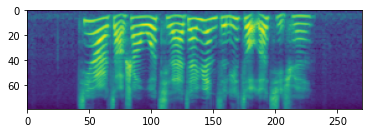

In [32]:
sample= dataset[5]
safe_log = lambda x: torch.log(x+2**(-15))
plt.imshow(safe_log(sample['audio'][0]))
''.join(sample['text']), sample['audio'].shape

('ji|er|ziao|sheng|wo|qi|la|jian|yuan|zhi|li|zhu|e|qi|qun',
 torch.Size([135, 28]))

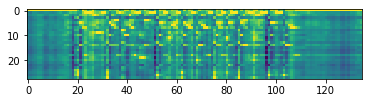

In [33]:
from utils.textDecoder import GreedyCTCDecoder, NaiveDecoder
# from utils.helper import get_labels
model.eval()
decoder = GreedyCTCDecoder(labels=get_labels())
out, _ = model(safe_log(sample['audio']))
p = torch.log_softmax(out, dim=-2)[0]
plt.imshow(p.detach().numpy(), interpolation='none')
decoder(p.T), p.T.shape

In [11]:
# model

In [12]:
decoder(out[0].T), out[0].T.shape

('ha||||||||||ha|||hia|||ha||||ha|||hua|||hi||||hi|||||a|||x-an||hi--||-a------------------------------------------------------------------',
 torch.Size([137, 28]))

In [13]:
from utils.dataset import SpeechDataset
class STCMDSDataset(SpeechDataset):

    def __init__(self, data_path, sample_rate=16000, transform=None):
        super().__init__(data_path, sample_rate, transform)
        files = os.listdir(data_path)
        file_names = []
        for file in files:
            if file.split('.')[1] == 'txt':
                file_names.append(file.split('.')[0])
        self.dataset_file_num = len(file_names)
        self.file_names = file_names
        self.threshold = 90000 # to avoid GPU memory used out
        self.batch_size = 128 # to avoid GPU memory used out
        self.split_ratio = [1000, 5]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        audio_name = self.get_audio(idx)
        waveform, sample_rate = torchaudio.load(audio_name)
        if sample_rate != self.sample_rate:
            waveform = torchaudio.functional.resample(waveform, sample_rate, self.sample_rate)
        audio_content = self.get_text(idx)
        sample = {'audio': waveform, 'text': audio_content}
        if self.transform:
            sample = self.transform(sample, self.sample_rate)
        return sample

    def get_audio(self, x): 
        return self.data_path+self.file_names[x]+'.wav' if x < self.dataset_file_num else None
        
    def get_text(self, x): 
        return open(self.data_path+self.file_names[x]+'.txt', "r").read() if x < self.dataset_file_num else None

dataset = STCMDSDataset('./data/ST-CMDS-20170001_1-OS/', transform=audio_transform)

('na-shuang-si-le-he-he-ni-jun-xun-wan-le-ma', torch.Size([1, 64, 274]))

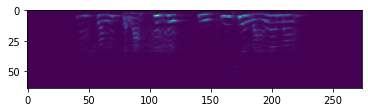

In [14]:
plt.imshow(dataset[0]['audio'][0])
''.join(dataset[0]['text']), dataset[0]['audio'].shape

In [15]:
from utils.dataset import LoaderGenerator
from torch.utils.data import DataLoader, Dataset, random_split
from utils.helper import get_labels
loaderGenerator = LoaderGenerator(get_labels(), k_size=33)
train_set, test_set = dataset.split()
train_loader = loaderGenerator.dataloader(train_set, batch_size=8)
print('train_set:', len(train_set), 'test_set:',len(test_set))
steps = 10
for i_batch, sample_batched in enumerate(train_loader):
    print(sample_batched['audio'].shape, sample_batched['target'].shape)
    # plt.imshow(sample_batched['audio'][0])
    # print(loaderGenerator.id2label(sample_batched['target'][0].tolist()))
    # print(sample_batched['audio_len'][0])
    # print(sample_batched['target_len'][0])
    # break
    if steps < 0:
        break
    steps -= 1


train_set: 102089 test_set: 511
torch.Size([7, 64, 308]) torch.Size([7, 64])
torch.Size([8, 64, 331]) torch.Size([8, 60])
torch.Size([8, 64, 298]) torch.Size([8, 62])
torch.Size([7, 64, 313]) torch.Size([7, 61])
torch.Size([8, 64, 288]) torch.Size([8, 61])
torch.Size([8, 64, 253]) torch.Size([8, 58])
torch.Size([8, 64, 336]) torch.Size([8, 57])
torch.Size([8, 64, 279]) torch.Size([8, 57])
torch.Size([7, 64, 307]) torch.Size([7, 49])
torch.Size([7, 64, 297]) torch.Size([7, 56])
torch.Size([8, 64, 323]) torch.Size([8, 53])
torch.Size([8, 64, 292]) torch.Size([8, 69])


In [16]:


class AiShellDataset(Dataset):

    def __init__(self, data_path, sample_rate=16000, transform=None):
        transcript_file = data_path+'transcript/aishell_transcript_v0.8.txt'
        self.transcript = self.gen_transcript(transcript_file)
        self.wav_files = self.get_all_wav_files(data_path, self.transcript)
        self.dataset_file_num = len(self.wav_files)
        self.data_path = data_path
        self.transform = transform
        self.sample_rate = sample_rate
        self.threshold = 120000 # to avoid GPU memory used out
        self.batch_size = 80 # to avoid GPU memory used out
        self.split_ratio = [1000, 1]

    def __len__(self):
        return self.dataset_file_num

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if idx >= self.dataset_file_num:
            return {'audio': None, 'text': None}
        audio_name = self.wav_files[idx]
        waveform, sample_rate = torchaudio.load(audio_name)
        waveform = waveform
        if sample_rate != self.sample_rate:
            waveform = torchaudio.functional.resample(waveform, sample_rate, self.sample_rate)
        dict_id = audio_name.rsplit('/',1)[-1].split('.')[0]
        audio_content = self.transcript[dict_id]
        sample = {'audio': waveform, 'text': audio_content}
        if self.transform:
            sample = self.transform(sample)
        return sample

    def parse_line(self, line):
        id, text = line.split(' ', 1)
        text = ''.join(text.split(' '))
        return id, text

    def gen_transcript(self, transcript_file):
        transcript = {}
        with open(transcript_file, 'r') as f:
            content = f.read()
            lines = content.split('\n')[:-1]
            for line in lines:
                id, text = self.parse_line(line)
                transcript[id] = text
        return transcript

    def get_all_wav_files(self, path, transcript):
        folders = []
        train = os.listdir(path+'wav/train/')
        folders += [path+'wav/train/'+i for i in train]
        dev = os.listdir(path+'wav/dev/')
        folders += [path+'wav/dev/'+i for i in dev]
        test = os.listdir(path+'wav/test/')
        folders += [path+'wav/test/'+i for i in test]
        files = []
        for folder in folders:
            files += [folder+'/'+i for i in os.listdir(folder) if i[:-4] in transcript]
        return files
    
    def split(self, split_ratio=None, seed=42):
        audio_dataset = self
        size = len(audio_dataset)
        my_split_ratio = self.split_ratio if split_ratio is None else split_ratio
        lengths = [(i*size)//sum(my_split_ratio) for i in my_split_ratio]
        lengths[-1] = size - sum(lengths[:-1])
        split_dataset = random_split(audio_dataset, lengths, generator=torch.Generator().manual_seed(seed))
        return split_dataset

In [17]:
if __name__ == '__main__':
    # dataset = AudioDataset('./data/ST-CMDS-20170001_1-OS/')
    dataset = AiShellDataset('./data/data_aishell/')
    batch_size = 8
    train_set, test_set = dataset.split([1000, 5])
    k_size = 5 # kernel size for audio encoder
    from pypinyin import lazy_pinyin
    def chinese2pinyin(text):
        pinyin = lazy_pinyin(text, strict=True,errors=lambda x: u'')
        pinyin = [i for i in '|'.join(pinyin)]
        return pinyin
    from utils.helper import get_labels
    from utils.dataset import LoaderGenerator
    labels = get_labels()
    loaderGenerator = LoaderGenerator(labels, chinese2pinyin, k_size)
    train_loader = loaderGenerator.dataloader(train_set, batch_size)
    test_loader = loaderGenerator.dataloader(test_set, batch_size) # without backprop, can use larger batch
    print('train_set:', len(train_set), 'test_set:',len(test_set))
    steps = 10
    for i_batch, sample_batched in enumerate(test_loader):
        print(sample_batched['audio'].shape, sample_batched['target'].shape)
        # for i in sample_batched['audio']:
        #     print(i.shape)
        if steps < 0:
            break
        steps -= 1

train_set: 140895 test_set: 705


TypeError: randint(): argument 'high' (position 1) must be int, not function

In [ ]:
dataset = AiShellDataset('./data/data_aishell/')
lens = [dataset[i]['audio'].shape[-1] for i in range(500)]

In [ ]:
lens2 = [dataset[i+500]['audio'].shape[-1] for i in range(1000)]

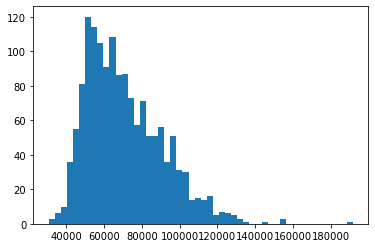

In [ ]:
import matplotlib.pyplot as plt
plt.hist(lens+lens2, bins = 50)
plt.show()

In [20]:
import json

In [21]:
import os
from numpy import dtype
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchaudio

class PrimeWordsDataset(Dataset):

    def __init__(self, data_path, sample_rate=16000, transform=None):
        with open(data_path+'set1_transcript.json') as f:
            json_data = json.load(f)
        self.json_data = json_data
        # self.wav_files = self.get_all_wav_files(data_path, self.transcript)
        self.dataset_file_num = len(self.json_data)
        self.data_path = data_path
        self.transform = transform
        self.sample_rate = sample_rate
        self.threshold = 220000 # to avoid GPU memory used out
        self.batch_size = 40 # to avoid GPU memory used out
        self.split_ratio = [1000, 2]

    def __len__(self):
        return self.dataset_file_num

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if idx >= self.dataset_file_num:
            return {'audio': None, 'text': None}
        audio_file, audio_content = self.parse_line(self.json_data[idx])
        waveform, sample_rate = torchaudio.load(self.get_wav(audio_file))
        waveform = waveform
        if sample_rate != self.sample_rate:
            waveform = torchaudio.functional.resample(waveform, sample_rate, self.sample_rate)
        sample = {'audio': waveform, 'text': audio_content}
        if self.transform:
            sample = self.transform(sample)
        return sample

    def parse_line(self, line):
        return line['file'], line['text']

    def get_wav(self, file_name):
        path = self.data_path+'audio_files/'+file_name[0]+'/'+file_name[:2]+'/'+file_name
        return path

    def split(self, split_ratio=None, seed=42):
        audio_dataset = self
        size = len(audio_dataset)
        my_split_ratio = self.split_ratio if split_ratio is None else split_ratio
        lengths = [(i*size)//sum(my_split_ratio) for i in my_split_ratio]
        lengths[-1] = size - sum(lengths[:-1])
        split_dataset = random_split(audio_dataset, lengths, generator=torch.Generator().manual_seed(seed))
        return split_dataset

In [22]:
if __name__ == '__main__':
    dataset = PrimeWordsDataset('./data/primewords_md_2018_set1/')
    batch_size = 8
    train_set, test_set = dataset.split([1000, 5])
    k_size = 5 # kernel size for audio encoder
    from pypinyin import lazy_pinyin
    def chinese2pinyin(text):
        pinyin = lazy_pinyin(text, strict=True,errors=lambda x: u'')
        pinyin = [i for i in '|'.join(pinyin)]
        return pinyin
    from utils.helper import get_labels
    from utils.dataset import LoaderGenerator
    labels = get_labels()
    loaderGenerator = LoaderGenerator(labels, chinese2pinyin, k_size)
    train_loader = loaderGenerator.dataloader(train_set, batch_size)
    test_loader = loaderGenerator.dataloader(test_set, batch_size) # without backprop, can use larger batch
    print('train_set:', len(train_set), 'test_set:',len(test_set))
    steps = 10
    for i_batch, sample_batched in enumerate(test_loader):
        print(sample_batched['audio'].shape, sample_batched['target'].shape)
        # for i in sample_batched['audio']:
        #     print(i.shape)
        if steps < 0:
            break
        steps -= 1

train_set: 50648 test_set: 254


TypeError: randint(): argument 'high' (position 1) must be int, not function

In [ ]:
dataset = PrimeWordsDataset('./data/primewords_md_2018_set1/')
lens = [dataset[i]['audio'].shape[-1] for i in range(500)]

In [ ]:
i=15
torchaudio.save('./audio-temp.wav', dataset[i]['audio'], 16000)
dataset[i]

{'audio': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0003, 0.0002, 0.0001]]),
 'text': '两碑尺寸相同 规格一致 均高六点八七米 分别由螭龙碑首'}

In [ ]:
lens2 = [dataset[i+500]['audio'].shape[-1] for i in range(1000)]

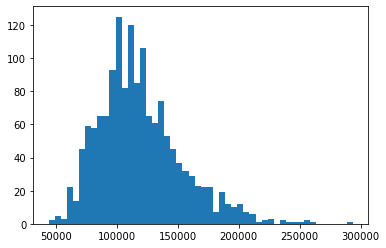

In [ ]:
import matplotlib.pyplot as plt
plt.hist(lens+lens2, bins = 50)
plt.show()

In [ ]:
import pandas as pd
data_path = './data/zhspeechocean/'


class SpeechOceanDataset(Dataset):
    def __init__(self, data_path, sample_rate=16000, transform=None):
        meta_data = data_path + 'metadata.csv'
        self.meta_data = pd.read_csv(meta_data, sep='\t')
        self.dataset_file_num = len(self.meta_data)
        self.data_path = data_path
        self.transform = transform
        self.sample_rate = sample_rate
        self.threshold = 90000 # to avoid GPU memory used out
        self.batch_size = 128 # to avoid GPU memory used out
        self.split_ratio = [100, 5]

    def __len__(self):
        return self.dataset_file_num

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if idx >= self.dataset_file_num:
            return {'audio': None, 'text': None}
        audio_name = os.path.join(self.data_path,
                                  self.meta_data.iloc[idx, 0])
        waveform, sample_rate = torchaudio.load(audio_name)
        audio_content = self.meta_data.iloc[idx, 1]
        if sample_rate != self.sample_rate:
            waveform = torchaudio.functional.resample(waveform, sample_rate, self.sample_rate)
        sample = {'audio': waveform, 'text': audio_content}
        if self.transform:
            sample = self.transform(sample)
        return sample

    def split(self, split_ratio=None, seed=42):
        audio_dataset = self
        size = len(audio_dataset)
        my_split_ratio = self.split_ratio if split_ratio is None else split_ratio
        lengths = [(i*size)//sum(my_split_ratio) for i in my_split_ratio]
        lengths[-1] = size - sum(lengths[:-1])
        split_dataset = random_split(audio_dataset, lengths, generator=torch.Generator().manual_seed(seed))
        return split_dataset

In [ ]:
if __name__ == '__main__':
    dataset = SpeechOceanDataset('./data/zhspeechocean/')
    batch_size = 8
    train_set, test_set = dataset.split([100, 5])
    k_size = 5 # kernel size for audio encoder
    from pypinyin import lazy_pinyin
    def chinese2pinyin(text):
        pinyin = lazy_pinyin(text, strict=True,errors=lambda x: u'')
        pinyin = [i for i in '|'.join(pinyin)]
        return pinyin
    from utils.helper import get_labels
    from utils.dataset import LoaderGenerator
    labels = get_labels()
    loaderGenerator = LoaderGenerator(labels, chinese2pinyin, k_size)
    train_loader = loaderGenerator.dataloader(train_set, batch_size)
    test_loader = loaderGenerator.dataloader(test_set, batch_size) # without backprop, can use larger batch
    print('train_set:', len(train_set), 'test_set:',len(test_set))
    steps = 10
    for i_batch, sample_batched in enumerate(test_loader):
        print(sample_batched['audio'].shape, sample_batched['target'].shape)
        # for i in sample_batched['audio']:
        #     print(i.shape)
        if steps < 0:
            break
        steps -= 1

train_set: 2285 test_set: 115
torch.Size([7, 76030]) torch.Size([7, 66])
torch.Size([8, 85818]) torch.Size([8, 66])
torch.Size([8, 80063]) torch.Size([8, 89])
torch.Size([7, 56436]) torch.Size([7, 54])
torch.Size([8, 76025]) torch.Size([8, 67])
torch.Size([8, 79484]) torch.Size([8, 68])
torch.Size([8, 65661]) torch.Size([8, 76])
torch.Size([8, 67958]) torch.Size([8, 75])
torch.Size([8, 59323]) torch.Size([8, 70])
torch.Size([8, 86392]) torch.Size([8, 66])
torch.Size([8, 55872]) torch.Size([8, 50])
torch.Size([8, 52413]) torch.Size([8, 47])


In [ ]:
dataset = SpeechOceanDataset('./data/zhspeechocean/')
lens = [dataset[i]['audio'].shape[-1] for i in range(2000)]

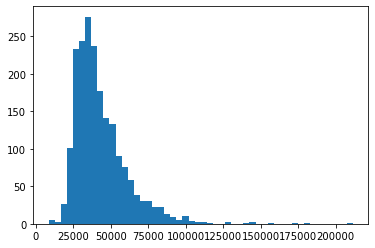

In [ ]:
import matplotlib.pyplot as plt
plt.hist(lens, bins = 50)
plt.show()

In [ ]:
i=15
torchaudio.save('./audio-temp.wav', dataset[i]['audio'], 16000)
dataset[i]

{'audio': tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -2.2709e-05,
          -7.3612e-05, -1.0139e-04]]),
 'text': '你这个周末有时间吗？你陪我去看看手机行吗？'}

In [ ]:
def chinese2pinyin(text):
    pinyin = lazy_pinyin(text, strict=True,errors=lambda x: u'')
    pinyin = [i for i in '|'.join(pinyin)]
    return pinyin
''.join(chinese2pinyin('你这个周末有时间吗？你陪我去看看手机行吗？'))

'ni|zhe|ge|zhou|mo|you|shi|jian|ma|ni|pei|wo|qu|kan|kan|shou|ji|xing|ma'

In [ ]:
class CvCorpus8Dataset(Dataset):

    def __init__(self, data_path, sample_rate=16000, transform=None):
        df1 = pd.read_csv(data_path+'validated.tsv',sep='\t')[['path', 'sentence']]
        # df2 = pd.read_csv(data_path+'invalidated.tsv',sep='\t')[['path', 'sentence']]
        # df3 = pd.read_csv(data_path+'other.tsv',sep='\t')[['path', 'sentence']]
        # df = pd.concat([df1, df2, df3])
        df = df1
        audio_path = df['path'].to_list()
        sentence_text = df['sentence'].to_list()
        assert len(audio_path) == len(sentence_text)
        self.audio_path = audio_path
        self.sentence_text = sentence_text
        self.size = len(audio_path)
        self.data_path = data_path
        self.transform = transform
        self.sample_rate = sample_rate
        self.threshold = 170000 # to avoid GPU memory used out
        self.batch_size = 64 # to avoid GPU memory used out
        self.split_ratio = [100, 1]

    def __len__(self):
        return len(self.audio_path)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        audio_name = self.get_audio(idx)
        waveform, sample_rate = torchaudio.load(audio_name)
        waveform = waveform
        if sample_rate != self.sample_rate:
            waveform = torchaudio.functional.resample(waveform, sample_rate, self.sample_rate)
        audio_content = self.get_text(idx)
        sample = {'audio': waveform, 'text': audio_content}
        if self.transform:
            sample = self.transform(sample)
        return sample

    def get_audio(self, x): 
        return self.data_path+'clips/'+self.audio_path[x] if x < len(self) else None
        
    def get_text(self, x): 
        return self.sentence_text[x] if x < len(self) else None
    
    def split(self, split_ratio=None, seed=42):
        audio_dataset = self
        size = len(audio_dataset)
        my_split_ratio = self.split_ratio if split_ratio is None else split_ratio
        lengths = [(i*size)//sum(my_split_ratio) for i in my_split_ratio]
        lengths[-1] = size - sum(lengths[:-1])
        split_dataset = random_split(audio_dataset, lengths, generator=torch.Generator().manual_seed(seed))
        return split_dataset

In [ ]:
if __name__ == '__main__':
    dataset = CvCorpus8Dataset('./data/cv-corpus-8.0-2022-01-19/zh-CN/')
    batch_size = 8
    train_set, test_set = dataset.split([100, 5])
    k_size = 5 # kernel size for audio encoder
    from pypinyin import lazy_pinyin
    def chinese2pinyin(text):
        pinyin = lazy_pinyin(text, strict=True,errors=lambda x: u'')
        pinyin = [i for i in '|'.join(pinyin)]
        return pinyin
    from utils.helper import get_labels
    from utils.dataset import LoaderGenerator
    labels = get_labels()
    loaderGenerator = LoaderGenerator(labels, chinese2pinyin, k_size)
    train_loader = loaderGenerator.dataloader(train_set, batch_size)
    test_loader = loaderGenerator.dataloader(test_set, batch_size) # without backprop, can use larger batch
    print('train_set:', len(train_set), 'test_set:',len(test_set))
    steps = 10
    for i_batch, sample_batched in enumerate(test_loader):
        print(sample_batched['audio'].shape, sample_batched['target'].shape)
        # for i in sample_batched['audio']:
        #     print(i.shape)
        if steps < 0:
            break
        steps -= 1

train_set: 44517 test_set: 2226
torch.Size([8, 124029]) torch.Size([8, 71])
torch.Size([8, 155901]) torch.Size([8, 126])
torch.Size([8, 148988]) torch.Size([8, 128])
torch.Size([8, 122877]) torch.Size([8, 110])
torch.Size([8, 142838]) torch.Size([8, 107])
torch.Size([8, 153984]) torch.Size([8, 131])
torch.Size([8, 142079]) torch.Size([8, 121])
torch.Size([8, 155904]) torch.Size([8, 90])
torch.Size([8, 131712]) torch.Size([8, 93])
torch.Size([8, 101753]) torch.Size([8, 94])
torch.Size([8, 97920]) torch.Size([8, 89])
torch.Size([8, 165877]) torch.Size([8, 140])


In [ ]:
dataset = CvCorpus8Dataset('./data/cv-corpus-8.0-2022-01-19/zh-CN/')

In [ ]:
i=18
torchaudio.save('./audio-temp.wav', dataset[i]['audio'], 16000)
dataset[i]

{'audio': tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0020, -0.0029, -0.0024]]),
 'text': '台湾北部地区家庭多以在农历年前时段包润饼则是在清明期间。'}